#**Deep Learning - CSE4006**
# LAB 13

> ## Name: **K CHARVI**
> ## Reg No: 19BCE7002
> ## Date: 17|11|2021
> ## Submitted To: Dr. BKSP Kumarraju Alluri


# Question: Implement the below research paper-"End to End Memory Networks"

# Paper-https://arxiv.org/pdf/1503.08895.pdf

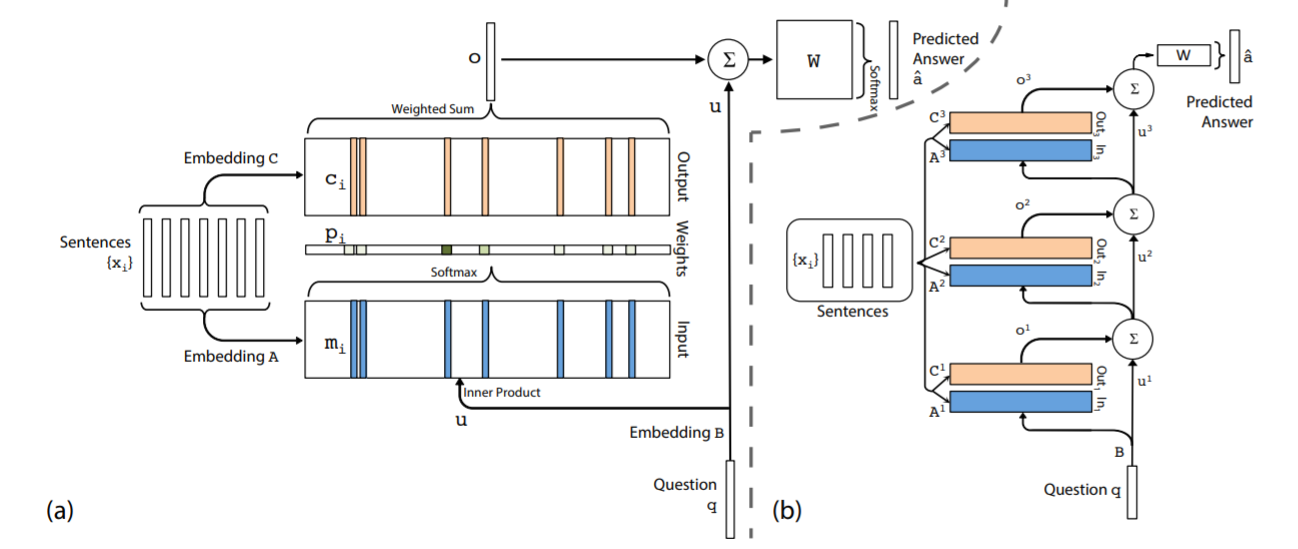

# Step 1: Load the dataset

In [2]:
%cd /content/drive/MyDrive/Deep learning LAB/LAB13

/content/drive/MyDrive/Deep learning LAB/LAB13


In [3]:
import pickle
import numpy as np

In [4]:
with open("train.txt", "rb") as fp:  
    train_data =  pickle.load(fp)

In [5]:
with open("test.txt", "rb") as fp:  
    test_data =  pickle.load(fp)

In [6]:
train_data

[(['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.'],
  ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
  'no'),
 (['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'went',
   'back',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.'],
  ['Is', 'Daniel', 'in', 'the', 'bathroom', '?'],
  'no'),
 (['Mary',
   'moved',
   'to',
   'the',
   'bathroom',
   '.',
   'Sandra',
   'journeyed',
   'to',
   'the',
   'bedroom',
   '.',
   'Mary',
   'went',
   'back',
   'to',
   'the',
   'bedroom',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'hallway',
   '.',
   'Sandra',
   'went',
   'to',
   'the',
   'kitchen',
   '.',
   'Daniel',
   'went',
   'back',
   'to',
   'the',
   'bathroom',
   '.'],
  ['Is', 'Daniel', 'in', 'the', '

In [7]:
train_data[0] 

(['Mary',
  'moved',
  'to',
  'the',
  'bathroom',
  '.',
  'Sandra',
  'journeyed',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'Sandra', 'in', 'the', 'hallway', '?'],
 'no')

In [8]:
' '.join(train_data[0][0]) 

'Mary moved to the bathroom . Sandra journeyed to the bedroom .'

In [9]:
' '.join(train_data[0][1]) 

'Is Sandra in the hallway ?'

In [10]:
train_data[0][2]

'no'

# Step 2: Prepare Vocabulary

In [11]:
# creating vocabulary of words in train and test set
vocab = set()
for story, q, answer in train_data + test_data:
    vocab |= set(story + q + [answer])

In [12]:
# sorting the vocabulary
vocab = sorted(vocab)

In [13]:
vocab #including yes and no-38 words

['.',
 '?',
 'Daniel',
 'Is',
 'John',
 'Mary',
 'Sandra',
 'apple',
 'back',
 'bathroom',
 'bedroom',
 'discarded',
 'down',
 'dropped',
 'football',
 'garden',
 'got',
 'grabbed',
 'hallway',
 'in',
 'journeyed',
 'kitchen',
 'left',
 'milk',
 'moved',
 'no',
 'office',
 'picked',
 'put',
 'the',
 'there',
 'to',
 'took',
 'travelled',
 'up',
 'went',
 'yes']

In [14]:
# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1

## Step 3: Generate Indexes

In [15]:
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer

In [16]:
# calculate maximum length of story
story_maxlen = max(map(len, (x for x, _, _ in train_data + test_data)))
 
# calculate maximum length of question/query
query_maxlen = max(map(len, (x for _, x, _ in train_data + test_data)))
 


In [17]:
# creating word to index dictionary
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
word_idx

{'.': 1,
 '?': 2,
 'Daniel': 3,
 'Is': 4,
 'John': 5,
 'Mary': 6,
 'Sandra': 7,
 'apple': 8,
 'back': 9,
 'bathroom': 10,
 'bedroom': 11,
 'discarded': 12,
 'down': 13,
 'dropped': 14,
 'football': 15,
 'garden': 16,
 'got': 17,
 'grabbed': 18,
 'hallway': 19,
 'in': 20,
 'journeyed': 21,
 'kitchen': 22,
 'left': 23,
 'milk': 24,
 'moved': 25,
 'no': 26,
 'office': 27,
 'picked': 28,
 'put': 29,
 'the': 30,
 'there': 31,
 'to': 32,
 'took': 33,
 'travelled': 34,
 'up': 35,
 'went': 36,
 'yes': 37}

In [18]:
# creating index to word dictionary
idx_word = dict((i+1, c) for i,c in enumerate(vocab))

In [19]:
idx_word

{1: '.',
 2: '?',
 3: 'Daniel',
 4: 'Is',
 5: 'John',
 6: 'Mary',
 7: 'Sandra',
 8: 'apple',
 9: 'back',
 10: 'bathroom',
 11: 'bedroom',
 12: 'discarded',
 13: 'down',
 14: 'dropped',
 15: 'football',
 16: 'garden',
 17: 'got',
 18: 'grabbed',
 19: 'hallway',
 20: 'in',
 21: 'journeyed',
 22: 'kitchen',
 23: 'left',
 24: 'milk',
 25: 'moved',
 26: 'no',
 27: 'office',
 28: 'picked',
 29: 'put',
 30: 'the',
 31: 'there',
 32: 'to',
 33: 'took',
 34: 'travelled',
 35: 'up',
 36: 'went',
 37: 'yes'}

### Step 4: Vectorization

In [20]:
def vectorize_stories(data, word_idx, story_maxlen, query_maxlen):
    # story vector initialization
    X = []
    # query vector initialization
    Xq = []
    # answer vector intialization
    Y = []
    for story, query, answer in data:
        # creating list of story word indices
        x = [word_idx[w] for w in story]
        # creating list of query word indices
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        y = np.zeros(len(word_idx) + 1)
        # creating label 1 for the answer word index
        y[word_idx[answer]] = 1
        X.append(x)
        Xq.append(xq)
        Y.append(y)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))

In [21]:
#inputs vectorized
# vectorize train story, query and answer sentences/word using vocab
inputs_train, queries_train, answers_train = vectorize_stories(train_data,
                                                               word_idx,
                                                               story_maxlen,
                                                               query_maxlen)
inputs_train

array([[ 0,  0,  0, ..., 30, 11,  1],
       [ 0,  0,  0, ..., 30, 19,  1],
       [ 0,  0,  0, ..., 30, 10,  1],
       ...,
       [ 0,  0,  0, ..., 30, 11,  1],
       [ 0,  0,  0, ..., 24, 31,  1],
       [ 0,  0,  0, ...,  8, 31,  1]], dtype=int32)

In [22]:
#Questions vectorized
# vectorize test story, query and answer sentences/word using vocab
inputs_test, queries_test, answers_test = vectorize_stories(test_data,
                                                            word_idx,
                                                            story_maxlen,
                                                            query_maxlen)
inputs_test

array([[ 0,  0,  0, ..., 30, 11,  1],
       [ 0,  0,  0, ..., 30, 16,  1],
       [ 0,  0,  0, ..., 30, 16,  1],
       ...,
       [ 0,  0,  0, ..., 30,  8,  1],
       [ 0,  0,  0, ..., 30, 16,  1],
       [ 0,  0,  0, ...,  8, 31,  1]], dtype=int32)

In [23]:
# Questions shape
queries_train.shape

(10000, 6)

In [24]:
# Vectorized Answers
answers_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [25]:
 #answer can be anything from 38 unique vocabulary words in train/test
 answers_train.shape

(10000, 38)

In [26]:
# No other answers other than Yes/No
answers_arr_train =np.zeros(len(word_idx) + 1)

for story, query, answer in train_data:
    answers_arr_train[word_idx[answer]]+= 1.0

    

In [27]:
answers_arr_train

array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0., 4988.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0., 5012.])

In [28]:
# No other answers other than Yes/No
answers_arr_test =np.zeros(len(word_idx) + 1)

for story, query, answer in test_data:
    answers_arr_test[word_idx[answer]]+= 1.0

In [29]:
answers_arr_test

array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 503.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0., 497.])

In [30]:
# index for "yes"

word_idx['yes']

37

In [31]:
# index for "No"
word_idx['no']

26

In [32]:
print('-------------------------')
print('Vocabulary:\n',vocab,"\n")
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_data))
print('Number of test stories:', len(test_data))
print('-------------------------')

-------------------------
Vocabulary:
 ['.', '?', 'Daniel', 'Is', 'John', 'Mary', 'Sandra', 'apple', 'back', 'bathroom', 'bedroom', 'discarded', 'down', 'dropped', 'football', 'garden', 'got', 'grabbed', 'hallway', 'in', 'journeyed', 'kitchen', 'left', 'milk', 'moved', 'no', 'office', 'picked', 'put', 'the', 'there', 'to', 'took', 'travelled', 'up', 'went', 'yes'] 

Vocab size: 38 unique words
Story max length: 156 words
Query max length: 6 words
Number of training stories: 10000
Number of test stories: 1000
-------------------------


## Step 5: Build the Model

In [33]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout
from keras.layers import add, dot, concatenate
from keras.layers import LSTM

#### Ensure that padding is done for content and questions

```return (pad_sequences(X, maxlen=story_maxlen),pad_sequences(Xq, maxlen=query_maxlen), np.array(Y))```

In [34]:
# number of epochs to run
train_epochs = 100
# Training batch size
batch_size = 32
# Hidden embedding size
embed_size = 50
# number of nodes in LSTM layer
lstm_size = 64
# dropout rate
dropout_rate = 0.30

In [35]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))
 
print('Input sequence:', input_sequence)
print('Question:', question)
 

Input sequence: KerasTensor(type_spec=TensorSpec(shape=(None, 156), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 6), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


## 5.1. Encoders

### Input Encoder m

In [36]:
# Input gets embedded to a sequence of vectors

# Use sequential() and Embedding() from keras

# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,output_dim=embed_size))


### 5.2 Input Encoder c

In [37]:
# encode the input of size questions max_length

# Use sequential() and Embedding() from keras

input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size, output_dim=query_maxlen))


### 5.3 Question Encoder

In [38]:
# encode the questions

# Use sequential() and Embedding() from keras

question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,output_dim=embed_size,input_length=query_maxlen))


### 5.4 Encode the Sequences

In [39]:
# Specify the maximum input and question dimensions

input_encoded_m = input_encoder_m(input_sequence)
print('Input encoded m', input_encoded_m)
input_encoded_c = input_encoder_c(input_sequence)
print('Input encoded c', input_encoded_c)
question_encoded = question_encoder(question)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 156, 50), dtype=tf.float32, name=None), name='sequential/embedding/embedding_lookup/Identity_1:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 156, 6), dtype=tf.float32, name=None), name='sequential_1/embedding_1/embedding_lookup/Identity_1:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 6, 50), dtype=tf.float32, name=None), name='sequential_2/embedding_2/embedding_lookup/Identity_1:0', description="created by layer 'sequential_2'")


### 5.5. Use dot product 

In [40]:
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: (samples, story_maxlen, query_maxlen)

match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
print(match.shape)
match = Activation('softmax')(match)
print('Match shape', match)
 

(None, 156, 6)
Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 156, 6), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")


### 5.6 Add this match matrix with the second input vector sequence

In [41]:
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)
print('Response shape', response)

Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 6, 156), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")


### 5.7. Concatenate and create LSTM network at the end and the model should have the following configuration

In [ ]:
# concatenate the response vector with the question vector sequence

answer = concatenate([response, question_encoded])
print('Answer shape', answer)

Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 6, 206), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [ ]:
#  create LSTM network at the end and the model should have the following configuration

answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 64
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

In [ ]:
# build the final model
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 156)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 6)]          0           []                               
                                                                                                  
 sequential (Sequential)        (None, None, 50)     1900        ['input_1[0][0]']                
                                                                                                  
 sequential_2 (Sequential)      (None, 6, 50)        1900        ['input_2[0][0]']                
                                                                                              

# 5.8. Train

In [ ]:
#train

history = model.fit([inputs_train, queries_train], answers_train, 
                    batch_size=batch_size, 
                    epochs=train_epochs,
                    validation_data=([inputs_test, queries_test], answers_test))

Epoch 1/100
313/313 [==============================] - 8s 15ms/step - loss: 0.7813 - accuracy: 0.4977 - val_loss: 0.6956 - val_accuracy: 0.5030
Epoch 2/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6997 - accuracy: 0.4994 - val_loss: 0.6949 - val_accuracy: 0.4970
Epoch 3/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6958 - accuracy: 0.4986 - val_loss: 0.6950 - val_accuracy: 0.4970
Epoch 4/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6941 - accuracy: 0.5127 - val_loss: 0.6947 - val_accuracy: 0.5030
Epoch 5/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6942 - accuracy: 0.5043 - val_loss: 0.6942 - val_accuracy: 0.5010
Epoch 6/100
313/313 [==============================] - 4s 13ms/step - loss: 0.6934 - accuracy: 0.5088 - val_loss: 0.6938 - val_accuracy: 0.4800
Epoch 7/100
313/313 [==============================] - 4s 12ms/step - loss: 0.6645 - accuracy: 0.5855 - val_loss: 0.6337 - val_accuracy:

### 5.9 Save the Model

In [ ]:
# save model
model.save('model_lab13_trial1_19bce7002.h5')

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


# 5.10 Evaluate on the test data

In [ ]:
# Use predict
test_data[0]

(['Mary',
  'got',
  'the',
  'milk',
  'there',
  '.',
  'John',
  'moved',
  'to',
  'the',
  'bedroom',
  '.'],
 ['Is', 'John', 'in', 'the', 'kitchen', '?'],
 'no')

In [ ]:
current_inp = test_data[0]
current_story, current_query, current_answer = vectorize_stories([current_inp], word_idx, story_maxlen, query_maxlen)
current_prediction = model.predict([current_story, current_query])
current_prediction = idx_word[np.argmax(current_prediction)]

In [ ]:
current_prediction

'no'

# Step 6: Add your own content and then test the build model

In [ ]:
my_input_data = [['John', 'moved', 'to', 'the', 'kitchen', '.', 'Sandra', 'journeyed', 'to', 'the', 'kitchen', '.'],['Is', 'Sandra', 'in', 'the', 'hallway', '?'],'yes']
# my_input_query = ['Is', 'Sandra', 'in', 'the', 'hallway', '?']

In [ ]:
my_input_story, my_input_query, my_input_ans = vectorize_stories([my_input_data], word_idx, story_maxlen, query_maxlen)



In [ ]:
check_current_prediction = model.predict([my_input_story, my_input_query])
check_current_prediction = idx_word[np.argmax(check_current_prediction)]

In [ ]:
check_current_prediction

'no'

Which is correct! Eventhough my_input_data we have given yes as answer it doesn't take into consideration anyways for predicting

# REFERENCES:

> https://appliedmachinelearning.blog/2019/05/02/building-end-to-end-memory-network-for-question-answering-system-on-babi-facebook-data-set-python-keras-part-2/

> https://becominghuman.ai/q-a-system-deep-learning-2-2-c0ad60800e3

> https://appliedmachinelearning.blog/2019/05/01/developing-factoid-question-answering-system-on-babi-facebook-data-set-python-keras-part-1/